# Logo Classification CNN Training

A robust CNN model for classifying logo images using **Transfer Learning with MobileNetV2**.

This notebook provides:
- Two-stage training (frozen base + fine-tuning)
- Heavy data augmentation for small datasets
- Callbacks for early stopping and learning rate reduction
- Training visualization
- Model evaluation with confusion matrix

## 1. Import Libraries

In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


## 2. Configuration

In [2]:
# Paths
DATA_DIR = pathlib.Path("data/logos_small")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "val"

# Hyperparameters
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 16
SEED = 42
EPOCHS_STAGE1 = 30  # Frozen base
EPOCHS_STAGE2 = 15  # Fine-tuning

## 3. Data Loading & Exploration

In [3]:
# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"\nClasses: {class_names}")
print(f"Number of classes: {num_classes}")

Found 52 files belonging to 4 classes.
Found 45 files belonging to 4 classes.

Classes: ['facebook', 'google', 'nike', 'youtube']
Number of classes: 4


In [4]:
# Count images per class
print("Training set distribution:")
for cls in os.listdir(TRAIN_DIR):
    cls_path = os.path.join(TRAIN_DIR, cls)
    if os.path.isdir(cls_path):
        count = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
        print(f"  {cls}: {count} images")

print("\nValidation set distribution:")
for cls in os.listdir(VAL_DIR):
    cls_path = os.path.join(VAL_DIR, cls)
    if os.path.isdir(cls_path):
        count = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
        print(f"  {cls}: {count} images")

Training set distribution:
  facebook: 14 images
  google: 14 images
  nike: 14 images
  youtube: 10 images

Validation set distribution:
  facebook: 14 images
  google: 14 images
  nike: 14 images
  youtube: 3 images


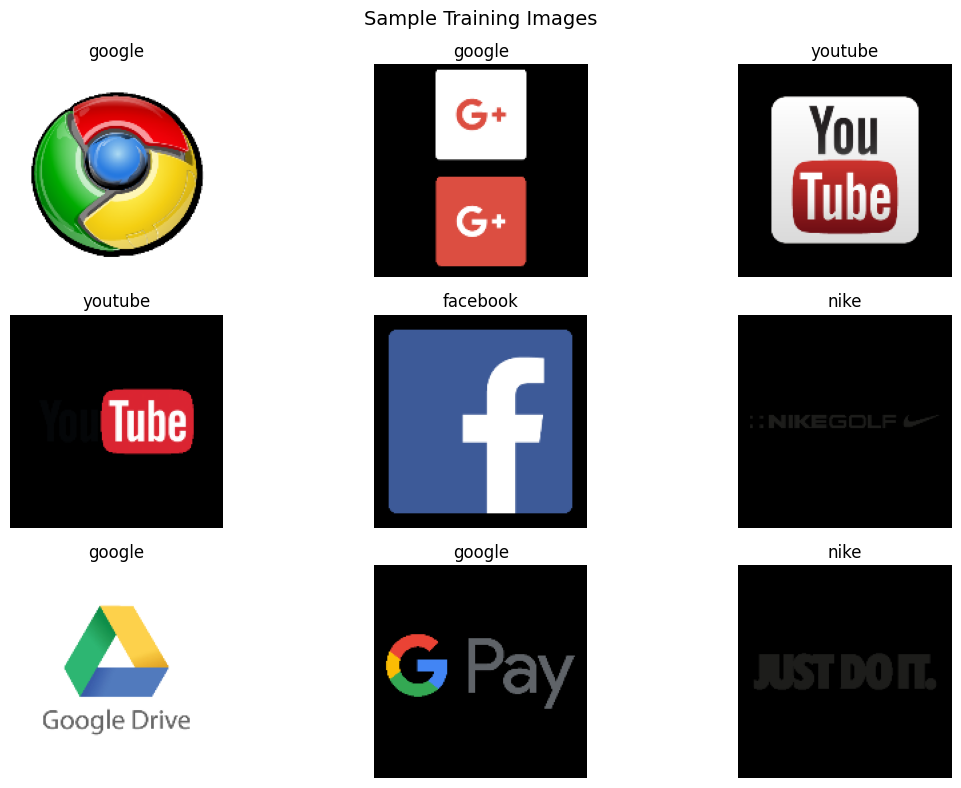

In [5]:
# Visualize sample images
plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_idx = np.argmax(labels[i])
        plt.title(class_names[label_idx])
        plt.axis("off")
plt.suptitle("Sample Training Images", fontsize=14)
plt.tight_layout()
plt.show()

## 4. Data Preprocessing & Augmentation

In [6]:
# Performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

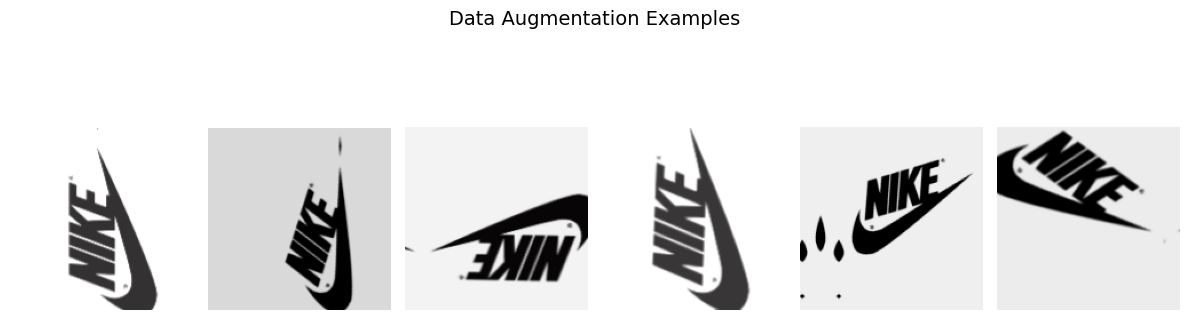

In [7]:
# Data Augmentation Layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.2, 0.2),
], name="data_augmentation")

# Visualize augmentation
plt.figure(figsize=(12, 4))
for images, _ in train_ds.take(1):
    image = images[0]
    for i in range(6):
        ax = plt.subplot(1, 6, i + 1)
        augmented = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented[0].numpy().astype("uint8"))
        plt.axis("off")
plt.suptitle("Data Augmentation Examples", fontsize=14)
plt.tight_layout()
plt.show()

## 5. Build CNN Model (Transfer Learning)

In [8]:
# Load pre-trained MobileNetV2
base_model = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet"
)

# Freeze the base model initially
base_model.trainable = False
print(f"Base model layers: {len(base_model.layers)}")

Base model layers: 154


In [9]:
# Build the complete model
inputs = keras.Input(shape=IMG_SHAPE, name="input_layer")
x = data_augmentation(inputs)
x = preprocess_input(x)  # MobileNetV2 preprocessing
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
x = layers.BatchNormalization(name="batch_norm")(x)
x = layers.Dropout(0.5, name="dropout_1")(x)
x = layers.Dense(256, activation="relu", name="dense_1")(x)
x = layers.Dropout(0.3, name="dropout_2")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="output")(x)

model = keras.Model(inputs, outputs, name="logo_classifier")
model.summary()

Model: "logo_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm (BatchNormalization) │ (None, 1280)           │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,068 (9.89 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

## 6. Stage 1: Train with Frozen Base

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_logo_model_stage1.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

In [11]:
print("STAGE 1: Training with Frozen Base Model...")
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

STAGE 1: Training with Frozen Base Model...
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3101 - loss: 2.1125
Epoch 1: val_accuracy improved from None to 0.55556, saving model to best_logo_model_stage1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3654 - loss: 2.0326 - val_accuracy: 0.5556 - val_loss: 1.0871 - learning_rate: 0.0010
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5944 - loss: 1.6577
Epoch 2: val_accuracy improved from 0.55556 to 0.71111, saving model to best_logo_model_stage1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - accuracy: 0.5962 - loss: 1.5018 - val_accuracy: 0.7111 - val_loss: 0.7726 - learning_rate: 0.0010
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6917 - loss: 0.9111
Epoch 3: val_accuracy improved from 0.71111 to 0.82222, saving model to best_logo_model_stage1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - accuracy: 0.6731 - loss: 1.0331 - val_accuracy: 0.8222 - val_loss: 0.5949 - learning_ra

## 7. Stage 2: Fine-tuning

In [12]:
# Unfreeze the top layers of the base model
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

print(f"Total layers in base model: {len(base_model.layers)}")
print(f"Trainable layers: {sum(1 for layer in base_model.layers if layer.trainable)}")

Total layers in base model: 154
Trainable layers: 30


In [13]:
# Re-compile with a lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint2 = ModelCheckpoint(
    "best_logo_model_finetuned.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

print("STAGE 2: Fine-tuning the Model...")
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=[early_stop, reduce_lr, checkpoint2]
)

STAGE 2: Fine-tuning the Model...
Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8373 - loss: 0.3748
Epoch 1: val_accuracy improved from None to 0.88889, saving model to best_logo_model_finetuned.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8077 - loss: 0.4277 - val_accuracy: 0.8889 - val_loss: 0.1980 - learning_rate: 1.0000e-05
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7678 - loss: 0.6134
Epoch 2: val_accuracy did not improve from 0.88889
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 0.7692 - loss: 0.5850 - val_accuracy: 0.8889 - val_loss: 0.1994 - learning_rate: 1.0000e-05
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8552 - loss: 0.5342
Epoch 3: val_accuracy did not improve from 0.88889
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step - accuracy: 0.8269 - loss: 0.5865 - val_accuracy: 0.8889 - val_loss: 0.2024 - learning_rate: 1.0000e-05
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.7630 - loss: 0.9701


## 8. Save Final Model

In [14]:
model.save("logo_classifier_final.keras")
print("Model saved as 'logo_classifier_final.keras'")

Model saved as 'logo_classifier_final.keras'


## 9. Training History Visualization

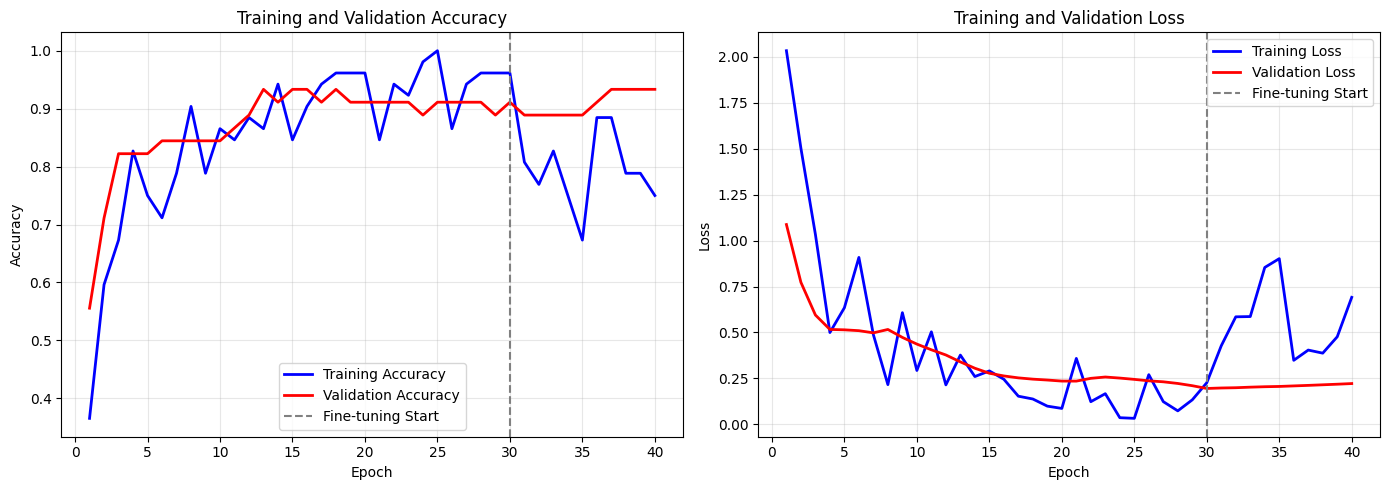

In [15]:
def plot_history(history1, history2=None):
    """Plot training history with optional two-stage visualization."""
    if history2:
        # Combine histories
        acc = history1.history["accuracy"] + history2.history["accuracy"]
        val_acc = history1.history["val_accuracy"] + history2.history["val_accuracy"]
        loss = history1.history["loss"] + history2.history["loss"]
        val_loss = history1.history["val_loss"] + history2.history["val_loss"]
        stage1_end = len(history1.history["accuracy"])
    else:
        acc = history1.history["accuracy"]
        val_acc = history1.history["val_accuracy"]
        loss = history1.history["loss"]
        val_loss = history1.history["val_loss"]
        stage1_end = None

    epochs_range = range(1, len(acc) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy Plot
    axes[0].plot(epochs_range, acc, 'b-', label="Training Accuracy", linewidth=2)
    axes[0].plot(epochs_range, val_acc, 'r-', label="Validation Accuracy", linewidth=2)
    if stage1_end:
        axes[0].axvline(x=stage1_end, color='gray', linestyle='--', label='Fine-tuning Start')
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Training and Validation Accuracy")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss Plot
    axes[1].plot(epochs_range, loss, 'b-', label="Training Loss", linewidth=2)
    axes[1].plot(epochs_range, val_loss, 'r-', label="Validation Loss", linewidth=2)
    if stage1_end:
        axes[1].axvline(x=stage1_end, color='gray', linestyle='--', label='Fine-tuning Start')
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Training and Validation Loss")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("training_history.png", dpi=150)
    plt.show()

plot_history(history1, history2)

## 10. Model Evaluation

In [16]:
# Collect predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification Report
print("Classification Report:")
print("-" * 50)
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

    facebook       0.82      1.00      0.90        14
      google       1.00      0.86      0.92        14
        nike       1.00      0.79      0.88        14
     youtube       0.60      1.00      0.75         3

    accuracy                           0.89        45
   macro avg       0.86      0.91      0.86        45
weighted avg       0.92      0.89      0.89        45



<Figure size 800x800 with 0 Axes>

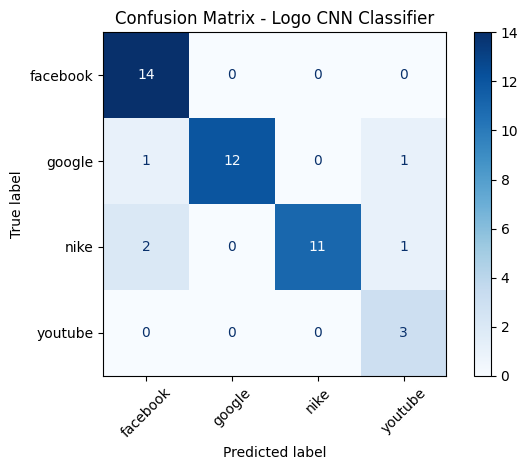

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Logo CNN Classifier")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150)
plt.show()

## 11. Prediction Function

In [18]:
def predict_logo(image_path, show_image=True):
    """
    Predict the logo class for a given image.
    
    Args:
        image_path: Path to the image file
        show_image: Whether to display the image
    
    Returns:
        Predicted class name and confidence
    """
    from tensorflow.keras.utils import load_img, img_to_array
    
    img = load_img(image_path, target_size=IMG_SIZE)
    arr = img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    
    preds = model.predict(arr, verbose=0)
    pred_idx = np.argmax(preds[0])
    pred_class = class_names[pred_idx]
    confidence = preds[0][pred_idx] * 100
    
    print(f"\nImage: {image_path}")
    print(f"Predicted: {pred_class} ({confidence:.2f}% confidence)")
    
    # Show all class probabilities
    print("\nAll predictions:")
    for i, (cls, prob) in enumerate(zip(class_names, preds[0])):
        print(f"  {cls}: {prob*100:.2f}%")
    
    if show_image:
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"{pred_class} ({confidence:.2f}%)")
        plt.axis("off")
        plt.show()
    
    return pred_class, confidence

Sample Predictions:

Image: data\logos_small\val\facebook\facebook-emoticons-preview-400x400.png
Predicted: facebook (95.72% confidence)

All predictions:
  facebook: 95.72%
  google: 1.94%
  nike: 0.00%
  youtube: 2.34%


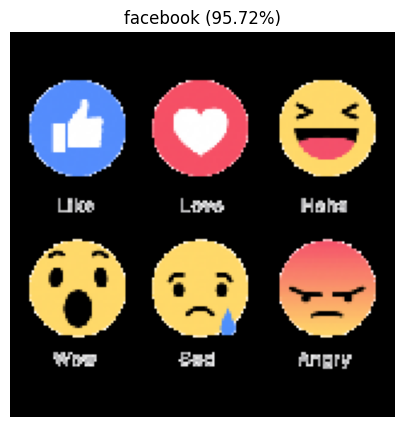


Image: data\logos_small\val\google\Android-app-on-Google-play-badge-vector.png
Predicted: google (98.56% confidence)

All predictions:
  facebook: 1.35%
  google: 98.56%
  nike: 0.04%
  youtube: 0.04%


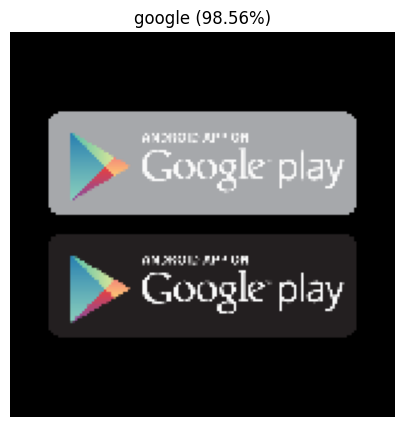


Image: data\logos_small\val\nike\nike-ball-vector-logo-400x400.png
Predicted: nike (95.76% confidence)

All predictions:
  facebook: 0.86%
  google: 0.66%
  nike: 95.76%
  youtube: 2.72%


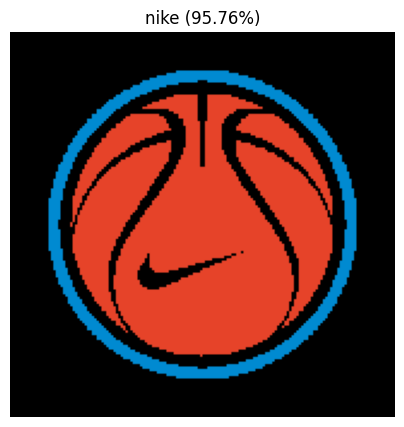

In [19]:
# Test predictions on validation images
print("Sample Predictions:")
print("=" * 50)

for cls in class_names[:3]:  # Test first 3 classes
    cls_path = VAL_DIR / cls
    if cls_path.exists():
        images = list(cls_path.glob("*.png")) + list(cls_path.glob("*.jpg"))
        if images:
            predict_logo(str(images[0]))

## 12. Summary

In [20]:
print("=" * 60)
print("Training Complete!")
print("=" * 60)

# Get final accuracies
final_train_acc = history2.history['accuracy'][-1] if history2 else history1.history['accuracy'][-1]
final_val_acc = history2.history['val_accuracy'][-1] if history2 else history1.history['val_accuracy'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")

print("\nFiles saved:")
print("  - logo_classifier_final.keras")
print("  - best_logo_model_stage1.keras")
print("  - best_logo_model_finetuned.keras")
print("  - training_history.png")
print("  - confusion_matrix.png")

Training Complete!

Final Training Accuracy: 75.00%
Final Validation Accuracy: 93.33%

Files saved:
  - logo_classifier_final.keras
  - best_logo_model_stage1.keras
  - best_logo_model_finetuned.keras
  - training_history.png
  - confusion_matrix.png
